In [1]:
import gc
import re
import pickle
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from pipelines import Pipeline
from utils import (
    camelcase_to_underscore, save_model, load_data, split_columns_by_types, kfold_with_respect_to_groups,
    reduce_mem_usage, Timer
)

%load_ext memory_profiler

In [2]:
df = load_data('train', 'input', sample_size=10000)
df.head()

Memory usage of dataframe is 2.21 MB
Memory usage after optimization is: 0.64 MB
Decreased by 71.1%


,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [3]:
columns = split_columns_by_types(df)
display(df[columns['id']].head(), df[columns['target']].head())

,id,group_id,match_id
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6


0    0.444336
1    0.640137
2    0.775391
3    0.166748
4    0.187500
Name: win_place_perc, dtype: float16

Drop NaN target

In [4]:
df.drop(df[df['win_place_perc'].isnull()].index, inplace=True)

Train

In [7]:
%%time
%%memit
from lightgbm import LGBMModel
from sklearn.metrics import mean_absolute_error

from assess import assess


model_params = dict(
    objective='regression',
    metric='mae',
    n_jobs=-1,
    learning_rate=0.1,
    n_estimators=2000,
)
assessment_log = assess(
    LGBMModel(**model_params), 
    df, 
    columns,
    metrics=mean_absolute_error,
    n_splits=5,
    early_stopping_rounds=20,
    verbose=1,
)


---------------------------
features.SimpleFeatureGenerator.transform 0:00:00.029351
features.GroupAggregatedFeatureGenerator.transform 0:00:00.224786
features.FeatureGenerator.transform 0:00:00.362891
preprocessing.Preprocessor.fit_transform 0:00:00.029240
pipelines.Pipeline.fit_transform: 0:00:00.448249
features.SimpleFeatureGenerator.transform 0:00:00.012974
features.GroupAggregatedFeatureGenerator.transform 0:00:00.110221
features.FeatureGenerator.transform 0:00:00.210428
preprocessing.Preprocessor.transform 0:00:00.007102
pipelines.Pipeline.transform: 0:00:00.271955
Data Preparation: 0:00:00.781521
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[163]	valid_0's l1: 0.0635864
Fitting: 0:00:01.452852
Saving: 0:00:00.153336
0.04585736553573672 0.06358638909537133
---------------------------


---------------------------
features.SimpleFeatureGenerator.transform 0:00:00.021825
features.GroupAggregatedFeatureGenerator.transform 0:00:00.

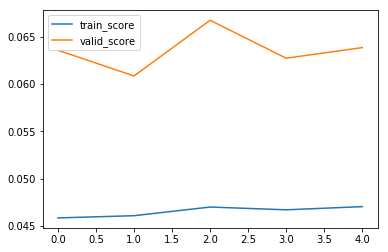

In [8]:
df_assessment = pd.DataFrame(assessment_log)
df_assessment[['train_score', 'valid_score']].plot()